# Benchmark Models

This notebook implements simple benchmark models to compare against LSTM performance:

In [1]:
!pip install -q scikit-learn

In [2]:
#| default_exp benchmark_model

In [3]:
#| hide
from nbdev.showdoc import *
from pathlib import Path
import hvplot.pandas
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

/home/i/Documentos/1_Proyectos/ombs_senegal/.venv/lib/python3.12/site-packages/nbdev/doclinks.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources,importlib


In [4]:
#| export
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [5]:
DATA = Path("../../data")

In [6]:
df = pd.read_csv(
    DATA/'data_cumul.csv', 
    sep=';', 
    usecols=['time', 'P_cumul_7j', 'débit_insitu', 'débit_mgb'], 
    index_col='time',
    converters={"time": pd.to_datetime}
    )

In [7]:
#| export
def normalize(df):
    return (df - df.min()) / (df.max() - df.min())

In [8]:
normalize(df).hvplot.line()

:NdOverlay   [Variable]
   :Curve   [time]   (value)

### Split data

In [9]:
train_mask = df.index < '2019-01-01'
x_col, y_col = ['P_cumul_7j','débit_mgb'], ['débit_insitu']
train = df[train_mask]
valid = df[~train_mask]

### Feature generator
> Feature generator that uses a sliding window of n previous timesteps and polynomial features to predict the next value, enabling learning of temporal patterns and non-linear relationships

In [10]:
#| export
class FeatureGenerator:
    """
    Transforms time series data into feature matrices suitable for machine learning models.
    Creates lagged features using a sliding window and optionally generates polynomial features
    to capture non-linear relationships between variables.
    """
    def __init__(self, context_window: int = 10, degree: int = 1):
        self.context_window = context_window
        self.poly_features = PolynomialFeatures(degree=degree)
        
    def generate(self, df: pd.DataFrame, x_col: list[str], y_col: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
        X, y = df[x_col], df[y_col]
        if 1 < self.poly_features.degree:
            X = pd.DataFrame(self.poly_features.fit_transform(X), index=X.index)
        X, y = self.generate_sliding_window_features(X, y)
        return X, y


    def generate_sliding_window_features(self, X: pd.DataFrame, y: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
        """
        Creates a feature matrix by combining multiple input variables and their lagged values.
        For each time step t, takes values from t-window to t for each input variable
        and combines them into a single feature vector. The target value is taken at time t.
        This allows the model to learn patterns across multiple timesteps.
        """
        features = []
        targets = []
        
        for i in range(len(X) - self.context_window):
            row_features = X.iloc[i:i + self.context_window]
            features.append(row_features.values.reshape(-1))
            targets.append(y.iloc[i + self.context_window])
        return pd.DataFrame(index=X.index[self.context_window:], data=features), pd.DataFrame(index=y.index[self.context_window:], data=targets)

In [11]:
feature_generator = FeatureGenerator(1, 2)
train_x, train_y = feature_generator.generate(train, x_col, y_col)


### Benchmark model
> We chose a linear regression model as our benchmark because:
> 1. When combined with our feature generator, it provides a simple yet effective baseline
> 2. The polynomial features allow it to capture non-linear relationships in the data
> 3. The sliding window enables learning of temporal patterns across multiple timesteps
> 4. Linear regression models are highly interpretable and computationally efficient

In [12]:
#| export
class SimpleRegressionModel:
    def __init__(self):
        self.model = LinearRegression()
    
    def fit(self, X, y=None):
        self.model.fit(X, y)
        return self
    
    def predict(self, X):
        prediction = self.model.predict(X)
        return pd.Series(prediction.reshape(-1), index=X.index)

### Model training and comparison

In [13]:
predictions = []
scores = []
for degree in range(1, 4):
    for window in range(10, 51, 10):
        feature_generator = FeatureGenerator(window, degree)        
        train_x, train_y = feature_generator.generate(train, x_col, y_col)
        valid_x, valid_y = feature_generator.generate(valid, x_col, y_col)

        model = SimpleRegressionModel()
        model.fit(train_x, train_y)
        pred = model.predict(valid_x)
        predictions.append({'degree': degree, 'window': window, 'time': valid_x.index.values, 'prediction': pred.values,})

        mse = round(mean_squared_error(valid_y, pred), 1)
        mae = round(mean_absolute_error(valid_y, pred), 1)
        # print(f"Degree: {degree}, Window: {window}, MSE: {mse}, MAE: {mae}")
        scores.append({'degree': degree, 'window': window, 'mse': mse, 'mae': mae})


Now we create a single dataset containg all the results

In [14]:
obs_ds= valid[y_col].to_xarray()

predictions = pd.DataFrame(predictions).explode(['prediction', 'time'])
predictions = predictions.set_index(['degree', 'window', 'time']).sort_index()
predictions_ds = predictions.to_xarray()

scores = pd.DataFrame(scores).set_index(['degree', 'window']).sort_index()
scores_ds = scores.to_xarray()

results_ds = predictions_ds.merge(scores_ds)
results_ds = results_ds.merge(obs_ds)

In [15]:
import matplotlib.pyplot as plt

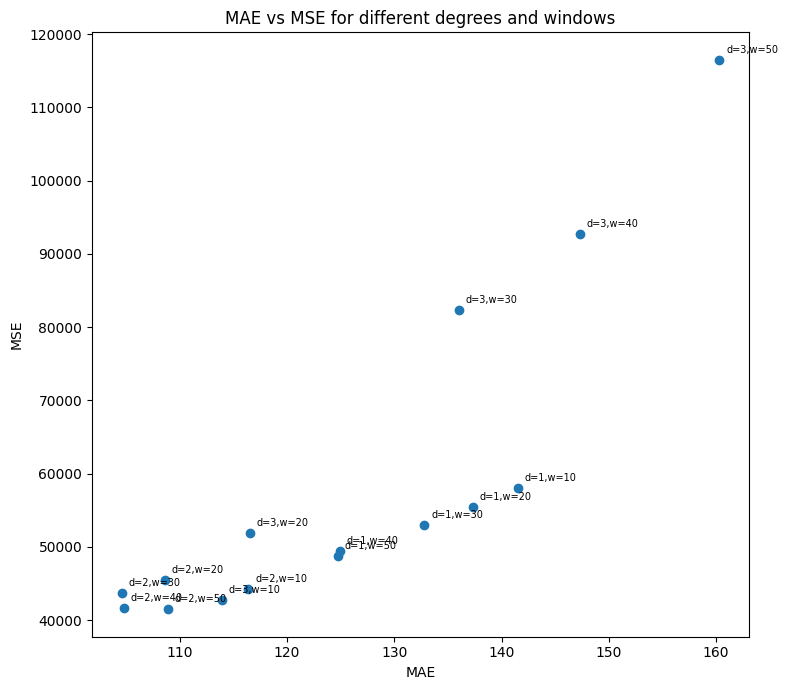

In [16]:
df = results_ds[["mae", "mse"]].to_dataframe()

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 7))

# Create scatter plot
ax.scatter(df['mae'], df['mse'])

# Add labels for each point
for idx, row in df.iterrows():
    ax.annotate(f'd={idx[0]},w={idx[1]}', 
                (row['mae'], row['mse']),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=7)

ax.set_xlabel('MAE')
ax.set_ylabel('MSE') 
ax.set_title('MAE vs MSE for different degrees and windows')

plt.tight_layout()
plt.show()

Based on the scatter plot comparing MAE vs MSE metrics, we can conclude that polynomial regression with degree 2 and window sizes between 30-50 days provides the optimal predictions. This is evident from the cluster of points in the lower left corner of the plot, which indicates lower error rates for both metrics. Specifically, the combinations of degree=2 with windows around 40 days achieve the best balance between Mean Absolute Error and Mean Squared Error, suggesting these parameters offer the most accurate and stable predictions without overfitting the data.

<Axes: xlabel='time'>

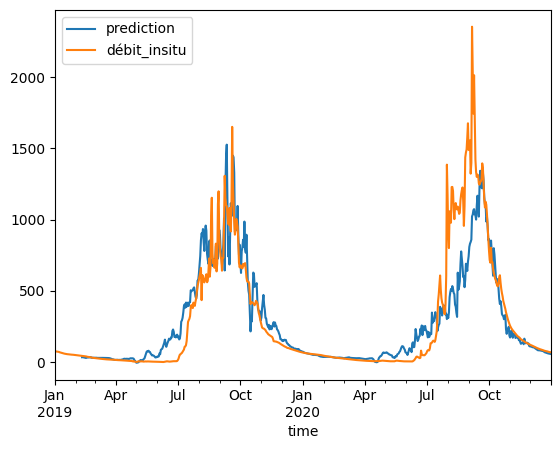

In [17]:
results_ds.sel(degree=2, window=40, drop=True)[["prediction", "débit_insitu"]].to_dataframe().plot()

We save the best model for later use

In [18]:
benchmark_ds = results_ds.sel(degree=2, window=40).rename({"prediction": "reg_benchamark"})
benchmark_ds.to_netcdf(DATA/'benchmark.nc')

In [19]:
#| hide
import nbdev; nbdev.nbdev_export()